In [8]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
model_path = r"deeplabv3_resumed_epoch30.pth"

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)

old_head = model.classifier
model.classifier = nn.Sequential(
    old_head[0],  # Conv2d
    old_head[1],  # BN
    old_head[2],  # ReLU
    old_head[3],  # Conv2d
    nn.Conv2d(256, num_classes, kernel_size=1) 
)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False) 
model.to(device)
model.eval()
print(" Model loaded ignoring classifier mismatch")


C:\Users\ilaki\AppData\Local\Temp\ipykernel_5824\3079719433.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


 Model loaded ignoring classifier mismatch


C:\Users\ilaki\AppData\Local\Temp\ipykernel_4392\1817570084.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


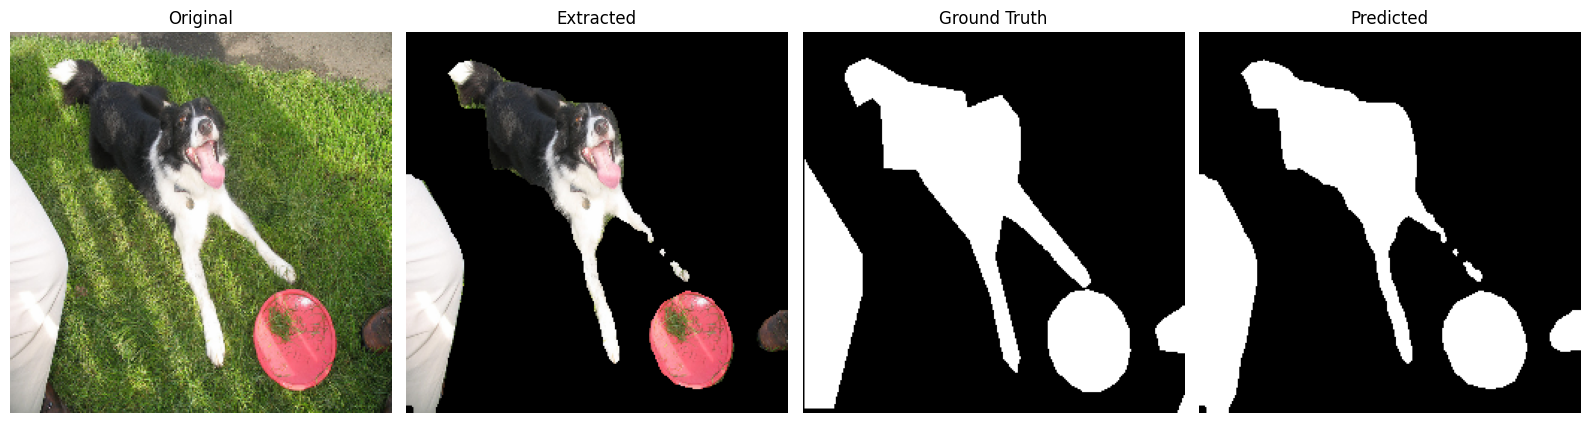

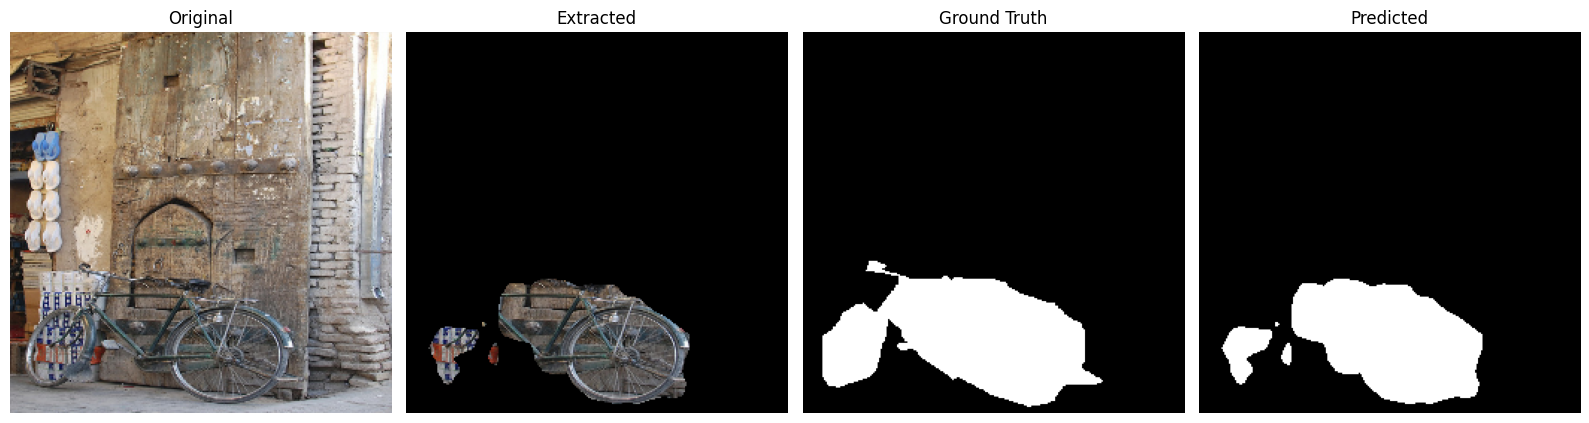

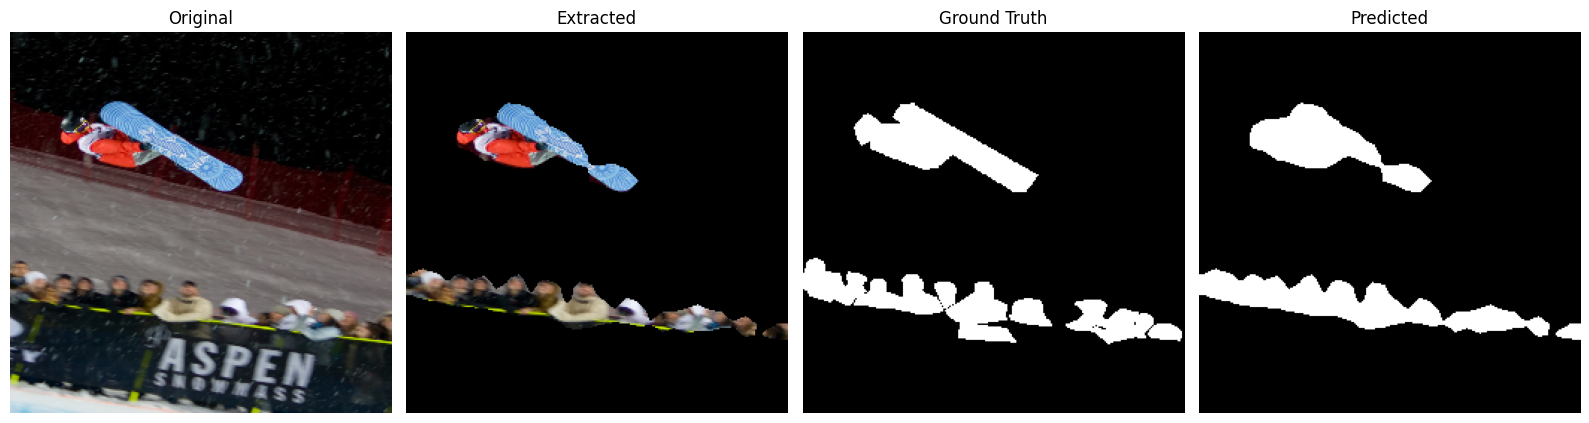

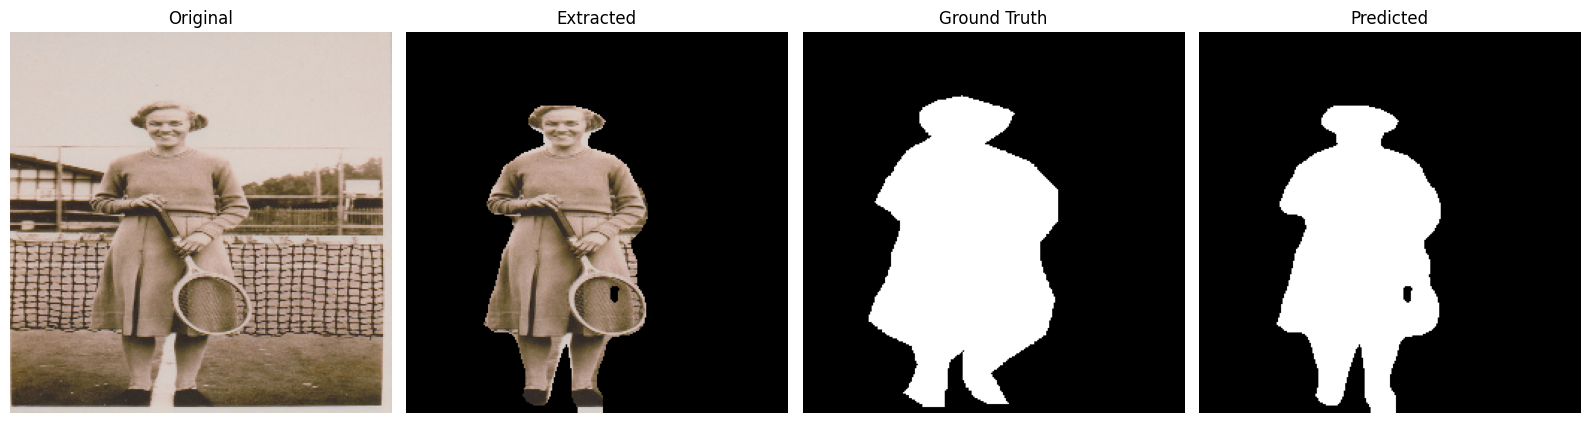

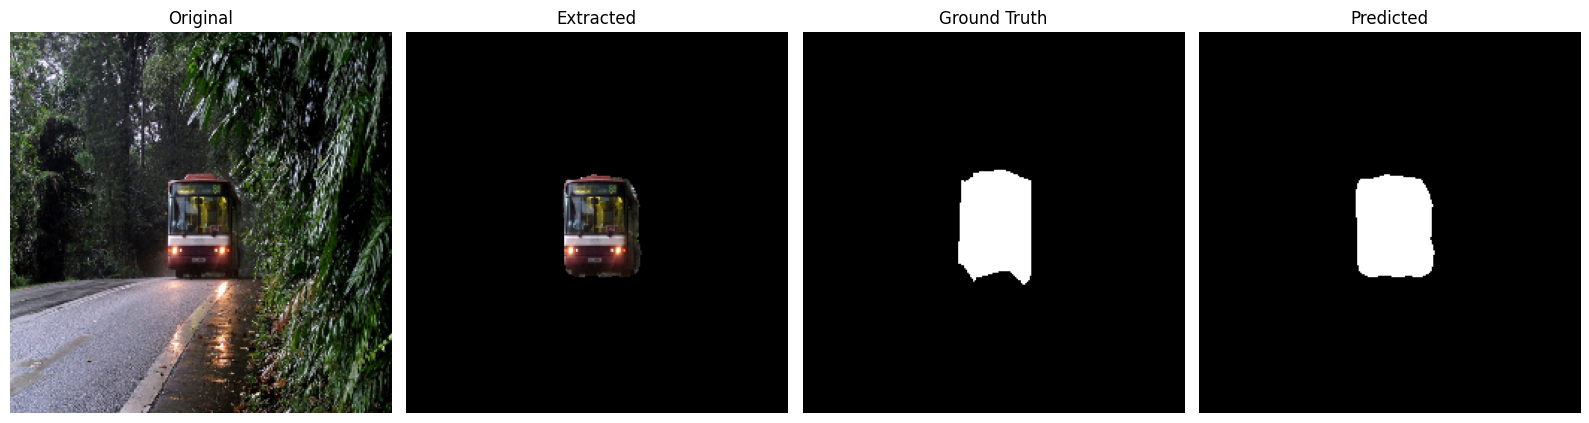

In [7]:
import os
import json
import random
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
image_size = 256
model_path = r"deeplabv3_resumed_epoch30.pth"
images_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\val2017"
annotations_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\annotations\instances_val2017.json"
output_dir = r"C:\Users\ilaki\Desktop\VISON_AI\old_model_extracted"
os.makedirs(output_dir, exist_ok=True)

val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        with open(annotations_path, "r") as f:
            coco = json.load(f)
        self.images = {img["id"]: img["file_name"] for img in coco["images"]}
        self.annotations = {}
        for ann in coco["annotations"]:
            img_id = ann["image_id"]
            self.annotations.setdefault(img_id, []).append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.images_path, self.images[img_id])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        for ann in self.annotations.get(img_id, []):
            for seg in ann["segmentation"]:
                if isinstance(seg, list) and len(seg) % 2 == 0:
                    poly = np.array(seg).reshape(-1, 2)
                    from skimage.draw import polygon
                    rr, cc = polygon(poly[:,1], poly[:,0], shape=img.shape[:2])
                    mask[rr, cc] = 1
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        return img, mask.long(), img_id

dataset = CocoMaskedDataset(images_path, annotations_path, transform=val_transform)

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights, aux_loss=True)
old_head = model.classifier
model.classifier = nn.Sequential(
    old_head[0], old_head[1], old_head[2], old_head[3],
    nn.Conv2d(256, num_classes, kernel_size=1)
)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

def denormalize(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
    return np.clip(img, 0, 1)

def extract_subject(img_np, mask_pred):
    return img_np * mask_pred[..., None]

indices = random.sample(range(len(dataset)), 5)

with torch.no_grad():
    for idx in indices:
        img_tensor, gt_mask, img_id = dataset[idx]
        img_input = img_tensor.unsqueeze(0).to(device)
        output = model(img_input)["out"]
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
        img_np = denormalize(img_tensor)
        extracted = extract_subject(img_np, pred_mask)
        gt_mask_np = gt_mask.squeeze().cpu().numpy()

        extracted_img = (extracted * 255).astype(np.uint8)
        Image.fromarray(extracted_img).save(os.path.join(output_dir, f"{img_id}.png"))

        fig, axs = plt.subplots(1, 4, figsize=(16, 6))
        axs[0].imshow(img_np)
        axs[0].set_title("Original"); axs[0].axis("off")
        axs[1].imshow(extracted)
        axs[1].set_title("Extracted"); axs[1].axis("off")
        axs[2].imshow(gt_mask_np, cmap="gray")
        axs[2].set_title("Ground Truth"); axs[2].axis("off")
        axs[3].imshow(pred_mask, cmap="gray")
        axs[3].set_title("Predicted"); axs[3].axis("off")
        plt.tight_layout()
        plt.show()


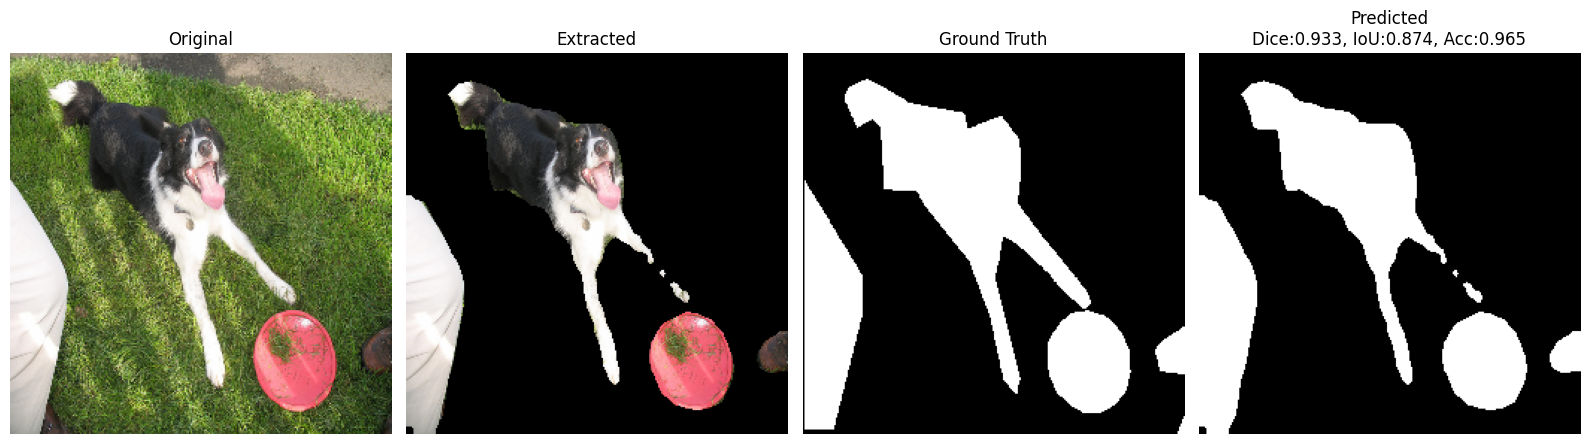

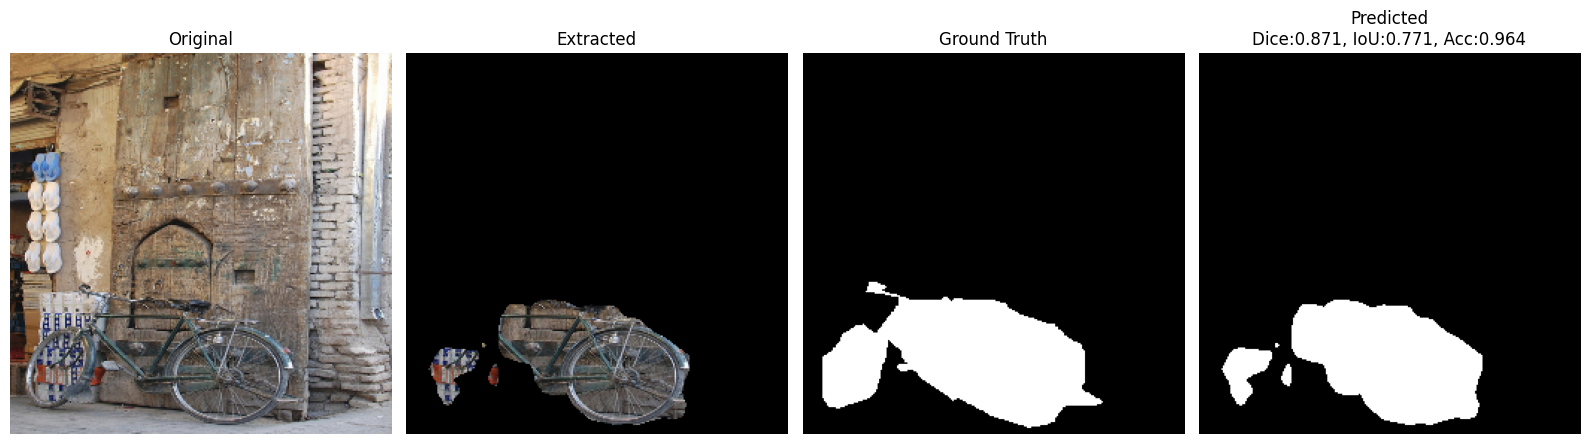

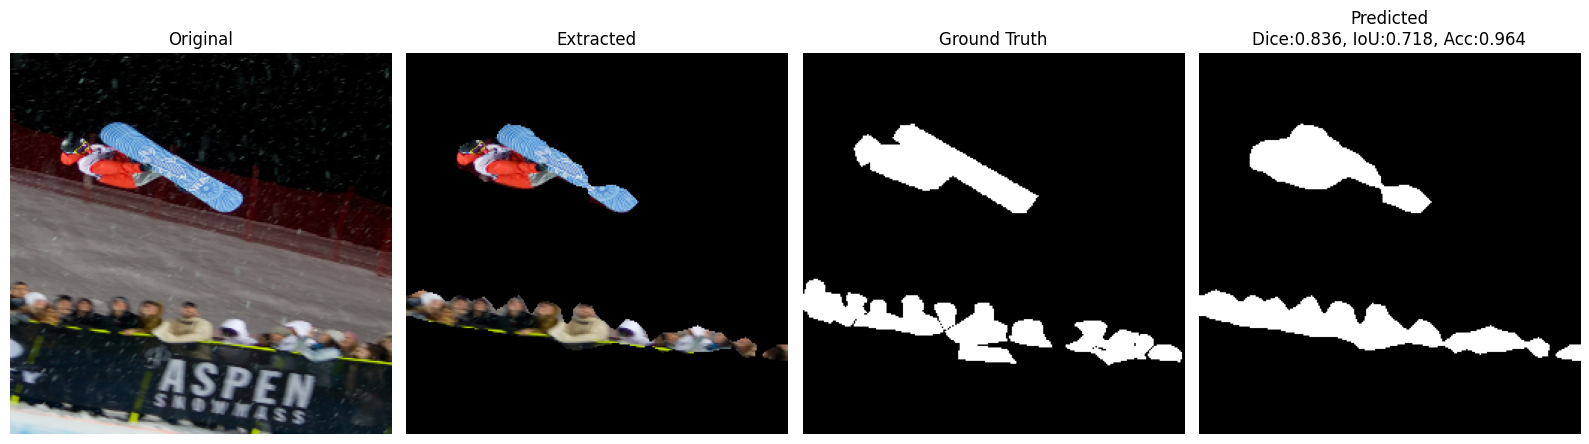

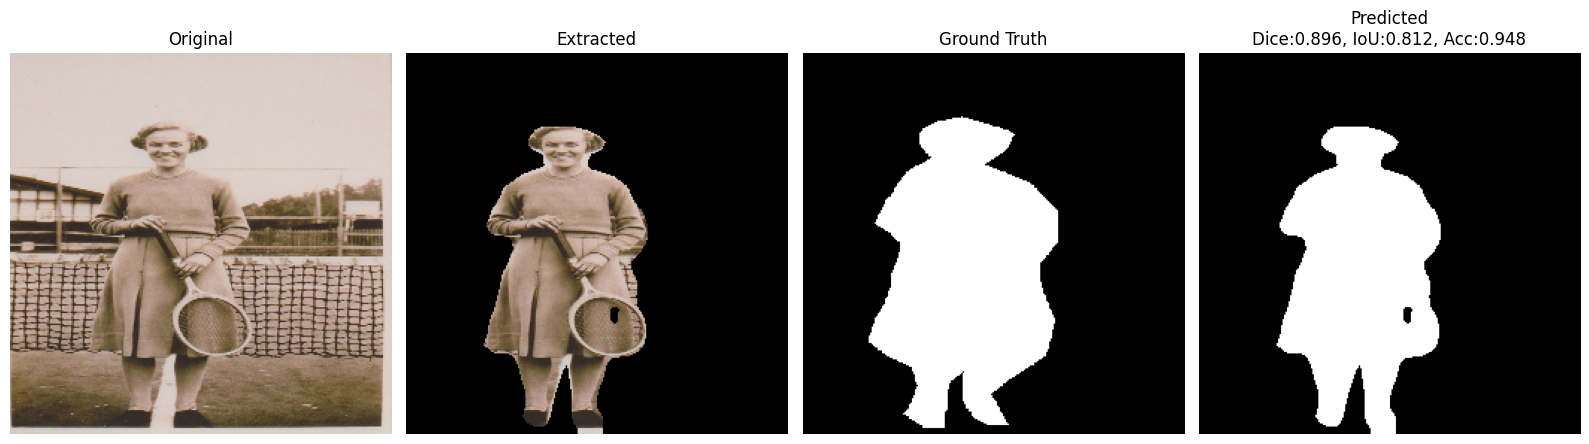

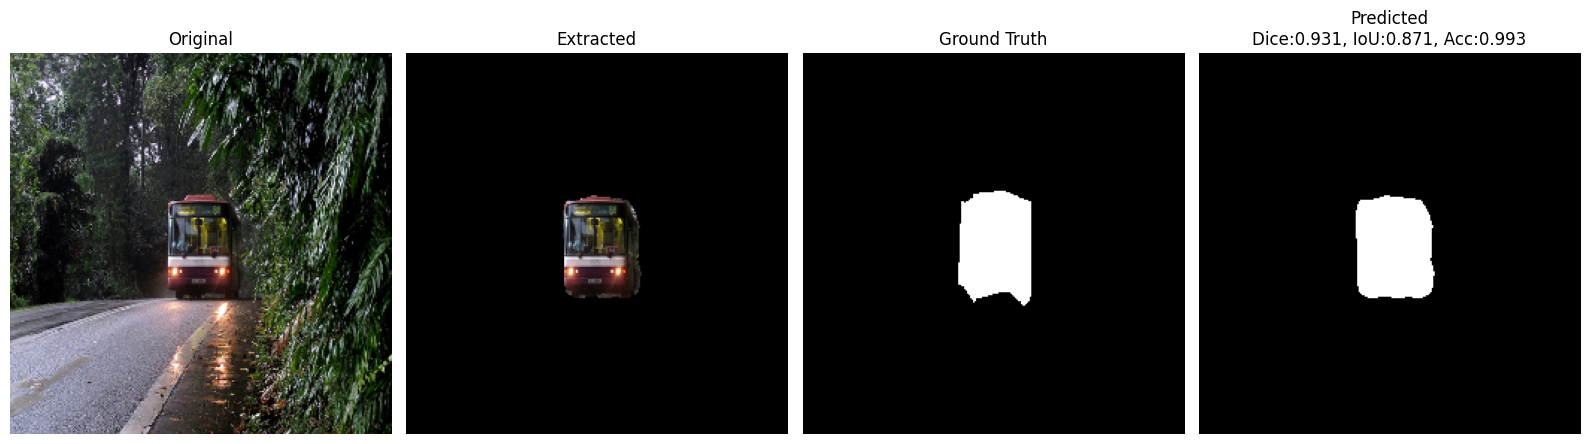

==== AVERAGED METRICS (Random 5) ====
Dice Coefficient: 0.8934
IoU Score:       0.8093
Pixel Accuracy:  0.9668


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def dice_coefficient(pred, target, eps=1e-6):
    intersection = np.sum(pred * target)
    return (2. * intersection + eps) / (np.sum(pred) + np.sum(target) + eps)

def iou_score(pred, target, eps=1e-6):
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return (intersection + eps) / (union + eps)

def pixel_accuracy(pred, target):
    return accuracy_score(target.flatten(), pred.flatten())

metrics = {"dice": [], "iou": [], "accuracy": []}

with torch.no_grad():
    for idx in indices:  
        img_tensor, gt_mask, img_id = dataset[idx]
        img_input = img_tensor.unsqueeze(0).to(device)

        output = model(img_input)["out"]
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        gt_mask_np = gt_mask.squeeze().cpu().numpy()

        pred_bin = (pred_mask > 0).astype(np.uint8)
        gt_bin = (gt_mask_np > 0).astype(np.uint8)

        dsc = dice_coefficient(pred_bin, gt_bin)
        iou = iou_score(pred_bin, gt_bin)
        acc = pixel_accuracy(pred_bin, gt_bin)

        metrics["dice"].append(dsc)
        metrics["iou"].append(iou)
        metrics["accuracy"].append(acc)

        fig, axs = plt.subplots(1, 4, figsize=(16, 6))
        img_np = denormalize(img_tensor)
        extracted = extract_subject(img_np, pred_bin)

        axs[0].imshow(img_np)
        axs[0].set_title("Original")
        axs[0].axis("off")

        axs[1].imshow(extracted)
        axs[1].set_title("Extracted")
        axs[1].axis("off")

        axs[2].imshow(gt_bin, cmap="gray")
        axs[2].set_title("Ground Truth")
        axs[2].axis("off")

        axs[3].imshow(pred_bin, cmap="gray")
        axs[3].set_title(f"Predicted\nDice:{dsc:.3f}, IoU:{iou:.3f}, Acc:{acc:.3f}")
        axs[3].axis("off")

        plt.tight_layout()
        plt.show()

print("==== AVERAGED METRICS (Random 5) ====")
print(f"Dice Coefficient: {np.mean(metrics['dice']):.4f}")
print(f"IoU Score:       {np.mean(metrics['iou']):.4f}")
print(f"Pixel Accuracy:  {np.mean(metrics['accuracy']):.4f}")
